## Ranking algorithms
### Authors: Amanda Bower, Lalit Jain
In this notebook, we develop three rank aggregation algorithms for the MMLS poster competition. We will use the Borda, Bradley-Terry-Luce, and Kemeny aggregation methods. For the Kemeny aggregation, we provide brute force code, an implementation using ``lpsolve`` and an implementation using ``cvxopt/.glpk``.

For more details, see LINK TO SHARELATEX PDF.

Throughout our code, a partial ranking denotes a list of the form ``[a,b,c,...]`` which indicates that item `a` is better than item `b`, item `b` is better than item `c` etc. 

In [1]:
import random
from collections import defaultdict
from itertools import combinations, permutations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# UTILITY FUNCTIONS

def build_N(rankings, n):
    '''
    Builds a nxn matrix from a set of rankings where the i-jth entry is the number of times i beats j
    rankings: a list of (partial) rankings
    n: number of items
    
    returns:
    N: nxn matrix whose (i,j)th entry is # times i beat j
    '''
    N = np.zeros((n,n))
    for r in rankings:
        for i in range(len(r)):
            for j in range(i+1, len(r)):
                N[r[i],r[j]] += 1
    return N

def kendalltau_dist(rank, partial):
    '''
    Computes the Kendall-Tau distance between a FULL ranking (rank) and a PARTIAL ranking (partial). 
    The Kendall-Tau distance in this case is the number of pairs (i,j) where rank ranks i and j in a different
    order from partial. If partial is a full ranking, this is the normal Kendall-Tau distance.
    '''
    d = 0
    rank_inv = dict(zip(rank, range(len(rank)) ))
    for i in range(len(partial)):
        for j in range(i+1, len(partial)):
            if rank_inv[partial[i]] > rank_inv[partial[j]]:
                d+=1
    return d

### Kemeny Aggregation Code
Kemeny aggregation finds a full ranking that minimizes the average distance to a set of partial rankings. In general
a difficult combinatorial optimization problem, it can be reformulated as an integer linear program in an easy way.

Our code is loosely based on the method here [http://vene.ro/blog/kemeny-young-optimal-rank-aggregation-in-python.html#note3](vene's blog).

In [2]:
def build_objective(N, extend=False):
    '''
    Returns the objective for the linear program.
    '''
    return N.ravel()

def build_constraints(n, solver='lpsolve'):
    '''
    In the lp formulation of Kemeny rank aggregation a nxn 0-1 matrix x is used to encode the permutation. 
    x satisfies: x[i,j] + x[j,i] = 1, and x[i,j]+x[j,k]+x[k,i] >= 1
    
    This method builds these constraints in the appropriate form for lpsolve and glpk.
    '''
    idx = lambda i, j: n * i + j

    #n choose 2 rows by n^2. rows are constraints and columns correspond to variables
    pairwise_constraints = np.zeros(((n * (n - 1)) / 2, n ** 2))
    for row, (i, j) in zip(pairwise_constraints, combinations(range(n), 2)):
        row[[idx(i, j), idx(j, i)]] = 1
    # and for every cycle of length 3
    triangle_constraints = np.zeros(((n * (n - 1) *(n - 2)), n ** 2))
    for row, (i, j, k) in zip(triangle_constraints, permutations(range(n), 3)):
        row[[idx(i, j), idx(j, k), idx(k, i)]] = 1

    if solver=='lpsolve':
        constraints = np.vstack([pairwise_constraints, triangle_constraints])
        constraint_rhs = np.hstack([np.ones(len(pairwise_constraints)),
                                    np.ones(len(triangle_constraints))])
        constraint_signs = np.hstack([np.zeros(len(pairwise_constraints)),
                                      np.ones(len(triangle_constraints))])   # ==
        return constraints, constraint_rhs, constraint_signs
    elif solver=='glpk':
        G = -1*triangle_constraints
        h = -1*np.ones(len(G))
        A = pairwise_constraints
        b = np.ones(len(A))
        return G,h,A,b
    else:
        raise

def kemeny_lpsolve(rankings, n):
    '''
    Kemeny rank aggregation using lpsolve55
    '''
    from lp_solve import lp_solve
    N = build_N(rankings, n)
    c = -1*build_objective(N)
    constraints, constraint_rhs, constraint_signs = build_constraints(n, 'lpsolve')
    obj, x, duals = lp_solve(c, constraints, constraint_rhs, constraint_signs.T)
                             #xint=range(1, 1 + n_candidates ** 2))
    x = np.array(x).reshape((n, n))
    aggr_rank = x.sum(axis=0)
    return obj, np.argsort(aggr_rank)[::-1], x

def kemeny_glpksolve(rankings,n):
    '''
    Kemeny rank aggregation using lpsolve55
    '''
    from cvxopt import matrix
    from cvxopt.glpk import ilp
    N = build_N(rankings, n)
    c = build_objective(N)
    G,h,A,b = build_constraints(n, 'glpk')
    status, x = ilp(c, matrix(G), matrix(h), matrix(A), matrix(b),
                    set(range(n**2)), set(range(n**2)))
    x = np.array(x).reshape((n, n))
    aggr_rank = x.sum(axis=0)
    return None, np.argsort(aggr_rank)[::-1], x

def rankaggr_brute(ranks, n):
    '''
    Kemeny rank aggregation using brute force methods. 
    DO NOT USE FOR n>9!!!
    '''
    min_dist = np.inf
    best_rank = defaultdict(int)
    count =0
    for candidate_rank in permutations(range(n)):
        if count % 100000 == 0:
            print 'Candidate ', count
        count +=1
        dist = np.sum(kendalltau_dist(candidate_rank, rank) for rank in ranks)
        if dist <= min_dist:
            min_dist = dist
            best_rank[candidate_rank]=dist
    
    min_dist = min(best_rank.values())
    return [key for key, value in best_rank.iteritems() if value == min_dist]



### Borda

In [3]:
def borda_reduction(rankings, n):
    '''
    Basic Borda Reduction method for computing the winner. 
    Computes the pairwise matrix N, and then normalizes the entries by the number of times i was compared to j.
    '''
    N = build_N(rankings, n)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                total = N[i,j]+N[j,i]
                if total == 0:
                    M[i,j] = 0
                else:
                    M[i,j] = N[i,j]*1.0 / total
    return np.argsort(np.sum(M, axis=1))[::-1]

def borda_reduction_score(rankings, n):
    '''
    Basic Borda Reduction method for computing the winner. 
    Computes the pairwise matrix N, and then normalizes the entries by the number of times i was compared to j.
    '''
    d = defaultdict(int)
    for r in ranks:
        for i in range(len(r)):
            d[r[i]] += 40-i
    return sorted([(x, d[x]) for x in rank_dict.keys()], key=lambda x:x[1])[::-1]
    



### Bradley-Terry-Luce

In [4]:
def btl(rankings, n):
    """
    Uses LogisticRegression to compute the btl scores based on the rankings. 
    """
    from sklearn.linear_model import LogisticRegression
    X,y = get_X_y(rankings, n)
    model = LogisticRegression(fit_intercept=False, verbose=True, C=1000000.)
    # parameter C controls regularization. High C => less regularization
    model = model.fit(X,y)
    print model.coef_.flatten()
    return np.argsort(model.coef_.flatten())[::-1]

def get_X_y(rankings,n):
    '''
    Build the X and y matrices for the Logistic regression classifier.
    '''
    num_comparisons = 0
    for r in rankings:
        num_comparisons += len(r)*(len(r)-1)/2
    num_comparisons = num_comparisons
    X = np.zeros((num_comparisons,n))
    y = np.zeros((num_comparisons))
    comparison =0
    for r in rankings:
        for i in range(len(r)-1):
            for j in range(i+1, len(r)):
                lower  = min(r[i], r[j])
                higher = max(r[i], r[j])
                X[comparison, lower]=1
                X[comparison, higher]=-1
                if(lower == r[i]):
                    y[comparison] = 1
                else:
                    y[comparison] = -1
                comparison +=1

    return X, y

# ACTUAL DATA RUN

how many ballots 39
averge length of ranking 5
Dictionary of item to number of times it was ranked
[(29, 1), (36, 1), (38, 1), (11, 2), (2, 3), (5, 3), (18, 3), (27, 3), (41, 3), (44, 3), (4, 4), (12, 4), (20, 4), (30, 4), (32, 4), (46, 4), (50, 4), (6, 5), (7, 5), (14, 5), (16, 5), (31, 5), (33, 5), (39, 5), (42, 5), (1, 6), (8, 6), (13, 6), (25, 6), (47, 6), (49, 6), (23, 7), (34, 7), (37, 7), (43, 7), (40, 9), (10, 10), (19, 11), (15, 13)]
Histogram of number of ranks an item appeared in


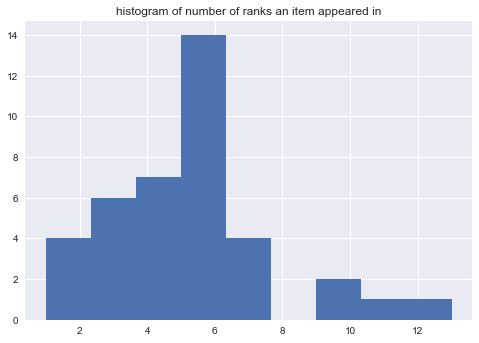

Which indices appear in a ranking.
39
Number of pairwise comparisons an item appeared in
pairwise_counts [ 33.   8.  22.  19.  32.  30.  39.   0.  49.   5.  34.  31.  32.  81.  33.
   9.  55.  15.  29.  44.  16.   4.  21.  43.  11.  19.  27.   4.  17.   2.
  23.  49.  28.  38.  33.  26.  34.  49.  49.  31.]
for item = 2 and judge =5 0.0


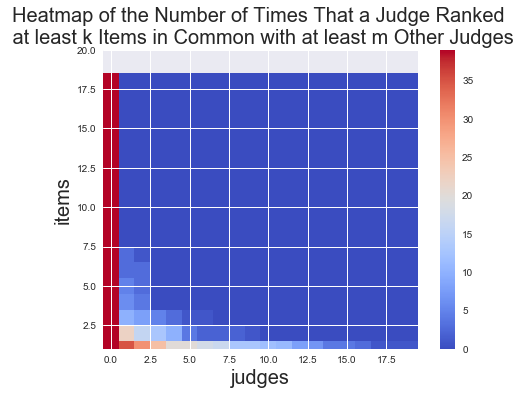

borda [15, 19, 10, 8, 37, 23, 33, 49, 30, 39, 40, 14, 2, 46, 34, 32, 1, 47, 27, 25, 42, 16, 11, 13, 6, 7, 43, 12, 50, 41, 38, 18, 20, 31, 9, 36, 5, 4, 44, 29]
borda using scores [15, 19, 10, 40, 37, 23, 34, 43, 1, 49, 47, 13, 25, 8, 39, 33, 6, 16, 7, 42, 14, 31, 32, 46, 20, 30, 50, 4, 12, 2, 18, 41, 27, 44, 5, 11, 38, 36, 29]


In [5]:
idxs = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
        16, 18, 19, 20, 23, 25, 27, 29, 30, 31, 32, 33, 
        34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 49, 50]
idx_dict = dict(zip(idxs, range(len(idxs))))

ranks = [[1, 15], [24, 16, 3, 18], [28, 26], [16, 4, 11, 18], [16, 11, 24, 25, 18], 
         [14, 29, 0], [20, 24, 8], [18, 28, 21, 13, 8], [6, 39, 2], [30, 0], 
         [6, 13, 5, 22, 31, 34], [6, 5, 27, 18, 34], 
         [33, 12, 2, 3], [28, 26, 17], 
         [9, 31], [0, 19, 14, 31, 23, 39, 35, 13, 33, 37], 
         [22, 25], 
         [38, 37, 33, 16, 4, 39, 36, 32, 22, 23, 10, 3, 12, 6], 
         [8, 31, 1, 11],  [8, 15, 33, 37], [25, 30, 4, 17], [25, 24, 8], 
         [22, 19, 16], [16, 8, 39, 11, 10, 38, 34, 26], [8, 30, 34, 31, 26, 12, 13], 
         [18, 6, 31, 36, 5, 12, 16], [1, 10, 30, 0, 20], [26, 16, 34], [28, 13, 31], 
         [13, 38, 4, 28, 8, 15], [37, 38, 16, 13, 30, 25, 11, 19, 8, 6], [17, 28, 26], 
         [13, 0, 2, 19, 31, 35, 10, 20, 23, 33, 14], 
         [31, 0, 19, 23, 35, 13, 14, 2], [36, 32, 38, 13, 37, 17, 4, 8, 5], [16, 28], 
         [13, 34, 14, 16, 11, 18], [12, 13, 34, 23, 9], [36, 38, 37, 32, 13, 5, 26, 19]]

print 'How many ballots', len(ranks)

length = 0
for r in ranks:
    length += len(r)

print 'Averge length of ranking', length/len(ranks)

# borda vs how many pairwise comparisons

print 'Dictionary of item to number of times it was ranked'
rank_dict = defaultdict(int)
for r in ranks:
    for i in r:
        rank_dict[i] +=1
print sorted([(idxs[x],rank_dict[x]) for x in rank_dict.keys()], key=lambda x:x[1])

print 'Histogram of number of ranks an item appeared in'
freqs = rank_dict.values()
plt.hist(freqs, bins='auto')
plt.title('histogram of number of ranks an item appeared in')
plt.show()

print 'Which indices appear in a ranking.'
idxs_appearing = []
for r in ranks:
    idxs_appearing += r
print len(set(idxs_appearing))


print 'Number of pairwise comparisons an item appeared in'
N = build_N(ranks, 40)
pairwise_counts = np.sum(N, axis=0)+np.sum(N, axis=1).T
print 'pairwise_counts', pairwise_counts

def num_k_m(ranks, k, m):
    counts = []
    ranks = [set(a) for a in ranks]
    for a in ranks:
        c = 0
        for b in ranks:
            if a!= b:
                if len(a.intersection(b)) >= k:
                    c += 1
        if c >= m:
            counts.append(1)
        else:
            counts.append(0)
    return sum(counts)

heatmap = np.zeros((19,20))
for k in range(1,20):
    for m in range(20):
        heatmap[k-1,m] = num_k_m(ranks, k, m)
        if k==2 and m==5:
            print 'for item = 2 and judge =5', heatmap[k,m]

import matplotlib.cm
fig, ax = plt.subplots()
plt.imshow(heatmap, interpolation='none', origin='lower', cmap=matplotlib.cm.coolwarm)
plt.title('Heatmap of the Number of Times That a Judge Ranked \n at least k Items in Common with at least m Other Judges', fontsize=20)
#plt.title('Heatmap of the Number of Times That a Judge Intersected At Least m Other Judges in at Least k Other Items')
plt.ylim(1,20)
plt.colorbar()
plt.xlabel('judges', fontsize=20)
plt.ylabel('items', fontsize=20)
plt.show()


n = 40
borda_aggr = borda_reduction([r[:min(3, len(r))] for r in ranks], n)
borda_score_aggr = borda_reduction_score(ranks, n)



#btl_aggr = btl(ranks, n)
#_, kemeny_aggr, x_lpsolve = kemeny_lpsolve(ranks, n)
#
print 'borda',[idxs[t] for t in borda_aggr]
print 'borda using scores', [idxs[t[0]] for t in borda_score_aggr]
#print 'btl', [t for t in btl_aggr]
#print 'kemeny', [idxs[t] for t in kemeny_aggr]

## Finalist Data

In [6]:
idxs_finalists = [10,15,19,37,40]
idx_dict_finalists = dict(zip(idxs_finalists, range(len(idxs_finalists))))
ranks_finalists = [[10, 15, 40, 37, 19],
                   [19, 40, 37, 10, 15],
                   [19, 10, 40, 37, 15],
                   [10, 37, 40, 15, 19],
                   [37, 15, 10, 40, 19], 
                   [37, 40, 10, 15, 19],
                   [19, 40, 10, 37, 15],
                   [37, 40, 10, 15, 19]
                  ]
ranks_finalists = [[idx_dict_finalists[j] for j in r] for r in ranks_finalists]
print ranks_finalists

n = 5

borda_aggr = borda_reduction(ranks_finalists, n)
borda_score_aggr = borda_reduction_score(ranks_finalists, n)
btl_aggr = btl(ranks_finalists, n)
_, kemeny_aggr, x_lpsolve = kemeny_lpsolve(ranks_finalists, n)
kemeny_brute = rankaggr_brute(ranks_finalists, n)

print 'borda',[idxs_finalists[t] for t in borda_aggr]
#print 'borda using scores', [idxs_finalists[t] for t in borda_score_aggr]
print 'btl', [idxs_finalists[t] for t in btl_aggr]
print 'kemeny', [idxs_finalists[t] for t in kemeny_aggr]
print 'kemeny brute force', [[idxs_finalists[t] for t in ranking] for ranking in kemeny_brute]


[[0, 1, 4, 3, 2], [2, 4, 3, 0, 1], [2, 0, 4, 3, 1], [0, 3, 4, 1, 2], [3, 1, 0, 4, 2], [3, 4, 0, 1, 2], [2, 4, 0, 3, 1], [3, 4, 0, 1, 2]]
[LibLinear][ 0.43552704 -0.77153864 -0.42587173  0.43552704  0.32635629]
m,n 70 25
Candidate  0
borda [37, 10, 40, 19, 15]
btl [10, 37, 40, 19, 15]
kemeny [40, 37, 10, 15, 19]
kemeny brute force [[37, 10, 40, 15, 19], [40, 37, 10, 15, 19], [37, 40, 10, 15, 19], [10, 37, 40, 15, 19], [40, 10, 37, 15, 19], [10, 40, 37, 15, 19]]


lp_solve.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if f == None:


### Validation on non-noisy data
In this example, we demonstrate the correctness of the above data on non-noisy data. 

In [7]:
'''
def sample(rank, k, t):
    """
    Generates a sample of partial rankings sampled from this ranking.
    rank: full ranking to sample from
    k: items per partial ranking
    t: number of partial rankings
    
    ranks: list of output rankings, a ranking [a,b,c, ..] implies that a>b>c>...
    """
    n = len(rank)
    ranks = []
    for i in range(t):
        ranks.append([rank[x] for x in sorted(random.sample(range(n),k))])
    return ranks
   
# generate true ranking on 50 items, 5 ranks per, 250 samples
n = 50; k = 5; num_samples = 300
tau = range(n); random.shuffle(tau)

# generate a large sample of partial rankings of size k from tau
i = 50
scores = []
while i < num_samples:
    print 'num samples:', i
    ranks = sample(tau, k, i)
    _, kemeny_aggr, x_lpsolve = kemeny_lpsolve(ranks, n)
    borda_aggr = borda_reduction(ranks, n)
    btl_aggr = btl(ranks, n)
    scores.append([kendalltau_dist(tau, kemeny_aggr), 
                   kendalltau_dist(tau, borda_aggr), 
                   kendalltau_dist(tau, btl_aggr)])
    i = min(i+50, num_samples)
'''

'\ndef sample(rank, k, t):\n    """\n    Generates a sample of partial rankings sampled from this ranking.\n    rank: full ranking to sample from\n    k: items per partial ranking\n    t: number of partial rankings\n    \n    ranks: list of output rankings, a ranking [a,b,c, ..] implies that a>b>c>...\n    """\n    n = len(rank)\n    ranks = []\n    for i in range(t):\n        ranks.append([rank[x] for x in sorted(random.sample(range(n),k))])\n    return ranks\n   \n# generate true ranking on 50 items, 5 ranks per, 250 samples\nn = 50; k = 5; num_samples = 300\ntau = range(n); random.shuffle(tau)\n\n# generate a large sample of partial rankings of size k from tau\ni = 50\nscores = []\nwhile i < num_samples:\n    print \'num samples:\', i\n    ranks = sample(tau, k, i)\n    _, kemeny_aggr, x_lpsolve = kemeny_lpsolve(ranks, n)\n    borda_aggr = borda_reduction(ranks, n)\n    btl_aggr = btl(ranks, n)\n    scores.append([kendalltau_dist(tau, kemeny_aggr), \n                   kendalltau_di

In [8]:
'''
scores = np.array(scores)
plt.plot(np.arange(50, num_samples, 50), scores[:,0], label='Kemeny')
plt.plot(np.arange(50, num_samples, 50), scores[:,1], label='Borda')
plt.plot(np.arange(50, num_samples, 50), scores[:,2], label='BTL')
plt.xlabel('Number of Samples')
plt.ylabel('Kendall Tau Distance from learned to truth')
plt.title('Comparison of Rank Aggregation Methods')
plt.legend()
plt.show()
'''


"\nscores = np.array(scores)\nplt.plot(np.arange(50, num_samples, 50), scores[:,0], label='Kemeny')\nplt.plot(np.arange(50, num_samples, 50), scores[:,1], label='Borda')\nplt.plot(np.arange(50, num_samples, 50), scores[:,2], label='BTL')\nplt.xlabel('Number of Samples')\nplt.ylabel('Kendall Tau Distance from learned to truth')\nplt.title('Comparison of Rank Aggregation Methods')\nplt.legend()\nplt.show()\n"